## K2-24 Fitting & Nested Sampling

Using the K2-24 (EPIC-203771098) dataset, we demonstrate how to use the radvel API to sample the posterior distribution and calculate the evidence with Nested Sampling.
A lot of the code here is copied from the [K2-24 MCMC tutorial](./tutorials/K2-24_Fitting+MCMC.ipynb), but adapted for nested sampling.
Instead of first fitting circular orbits and then eccentric orbits, we will compare models with one and two planets.

### Single-planet model

Perform some preliminary imports:

In [1]:
import os

import matplotlib
import numpy as np
import pylab as pl
import pandas as pd
from scipy import optimize

import corner

import radvel
import radvel.likelihood
from radvel.plot import orbit_plots, mcmc_plots
import matplotlib.pyplot as plt

matplotlib.rcParams['font.size'] = 14

/home/vandal/miniforge3/envs/radvel/lib/python3.10/site-packages/docutils/utils/code_analyzer.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound as ResourceError


Define a function that we will use to initialize the ``radvel.Parameters``, ``radvel.RVModel``, ``radvel.RVLikelihood``, and ``Radvel.Posterior`` objects.
The number of planets is an argument so we can re-use the function to generate the model later.

In [2]:
def initialize_model(num_planets):
    time_base = 2420
    params = radvel.Parameters(num_planets,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    if num_planets == 2:
        params['per2'] = radvel.Parameter(value=42.363011)
        params['tc2'] = radvel.Parameter(value=2082.62516)
        params['secosw2'] = radvel.Parameter(value=0.01)
        params['sesinw2'] = radvel.Parameter(value=0.01)
        params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)

    like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
    like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
    like.params['jit'] = radvel.Parameter(value=1.0)
    like.params['secosw1'].vary = False
    like.params['sesinw1'].vary = False
    like.params['per1'].vary = False
    like.params['tc1'].vary = False
    if num_planets == 2:
        like.params['secosw2'].vary = False
        like.params['sesinw2'].vary = False
        like.params['per2'].vary = False
        like.params['tc2'].vary = False

    post = radvel.posterior.Posterior(like)
    post.priors += [radvel.prior.Gaussian('jit', np.log(3), 0.5)]
    post.priors += [radvel.prior.Gaussian('logk1', np.log(5), 10)]
    post.priors += [radvel.prior.Gaussian('dvdt', 0, 1.0)]
    post.priors += [radvel.prior.Gaussian('curv', 0, 1e-1)]
    if num_planets == 2:
        post.priors += [radvel.prior.Gaussian('logk2', np.log(5), 10)]

    return post

Define a simple plotting function to display the data, model, and residuals

In [3]:
def plot_results(like):
    fig = pl.figure(figsize=(12,4))
    fig = pl.gcf()
    fig.set_tight_layout(True)
    pl.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    pl.plot(ti, like.model(ti))
    pl.xlabel('Time')
    pl.ylabel('RV')
    pl.draw()

Load up the K2-24 data. In this example the RV data and parameter starting guesses are stored in a csv file.

In [4]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = pd.read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [5]:
post = initialize_model(1)
print(post)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1      False
jit                               1       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          3.00417           

Priors
------
Gaussian prior on jit, mu=1.0986122886681096, sigma=0.5
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on dvdt, mu=0, sigma=1.0
Gaussian prior on curv, mu=0, sigma=0.1



Plot the initial model

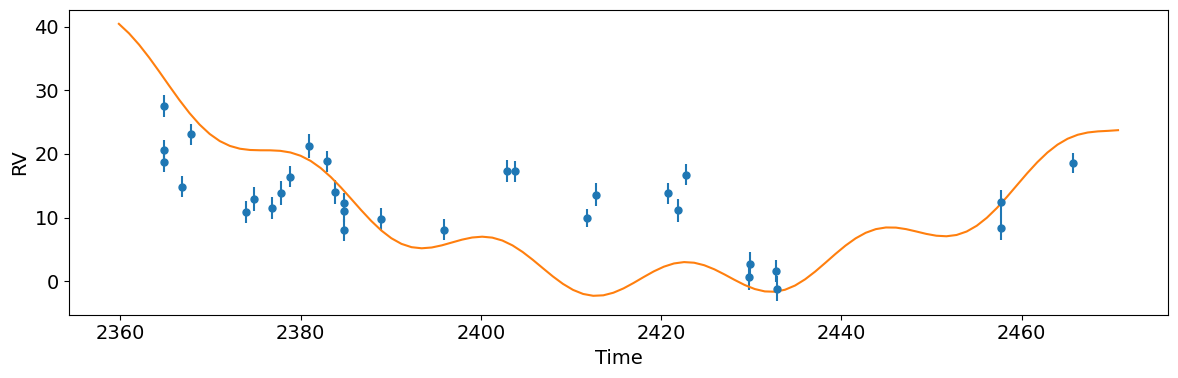

In [6]:
plot_results(post.likelihood)
plt.show()

Well that solution doesn't look very good. Now lets try to optimize the parameters set to vary by maximizing the likelihood and printing the updated posterior object.

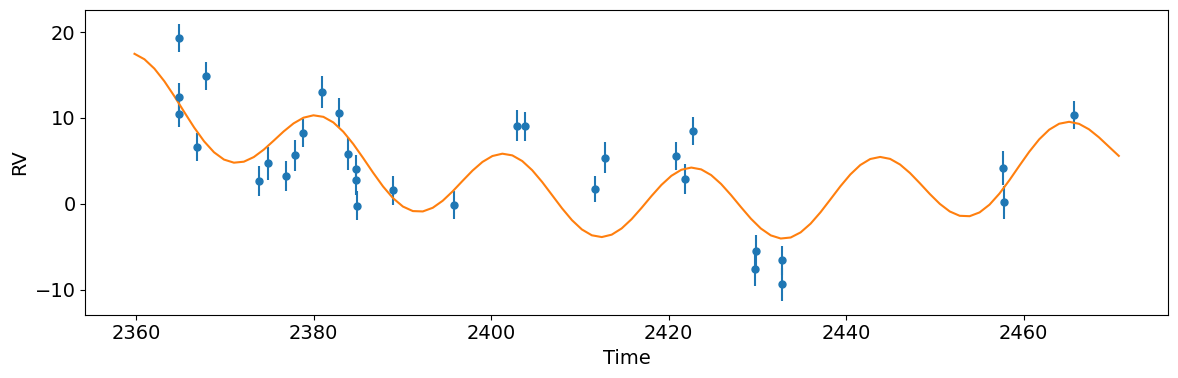

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.45048       True
dvdt                     -0.0258229       True
curv                     0.00321625       True
gamma                      -5.48058      False
jit                         3.72765       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          4.26516           

Priors
------
Gaussian prior on jit, mu=1.0986122886681096, sigma=0.5
Gaussian prior on logk1, mu=1.6094379124341003, sigma=10
Gaussian prior on dvdt, mu=0, sigma=1.0
Gaussian prior on curv, mu=0, sigma=0.1



In [7]:
res  = optimize.minimize(
    post.likelihood.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Nelder-Mead',           # Powell also works
    )
bic_circular = post.likelihood.bic()
plot_results(post.likelihood)             # plot best fit model
plt.show()
print(post)

Now lets use Nested Sampling to estimate the parameter uncertainties and bayesian evidence!

#### Prior check

Before running the inference, it is always a good idea to check the prior to make sure it produces the samples we expect.
We can easily do this by generating uniform samples and transforming them to prior space using ``radvel.Posterior.prior_transform()``.

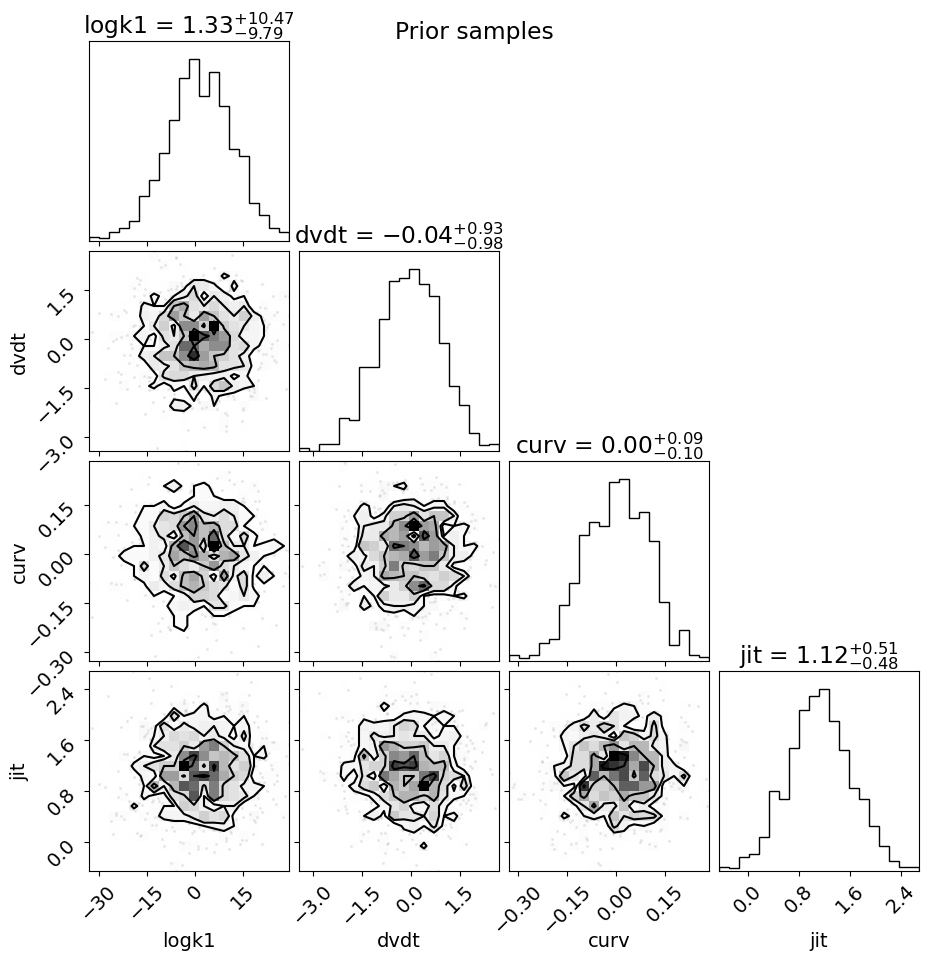

In [8]:
u = np.random.random(size=(len(post.priors), 1000))
prior_samples = post.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=post.name_vary_params(), show_titles=True)
fig.suptitle("Prior samples")
plt.show()

#### Sampling

We can then run nested sampling with a single planet.
By default, RadVel uses [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html) under the hood.
For other available nested sampling packages in RadVel, see the [Available Nested Samplers](./tutorials/k2_24_demo_all_samplers.ipynb)
Keyword arguments can be passed to UltraNest's ``ReactiveNestedSampler`` and ``ReactiveNestedSampler.run()`` via
the ``sampler_kwargs`` and ``run_kwargs`` dictionaries, respectively.

The RadVel function returns  a dictionary with the posterior samples, the log-evidence, and the uncertainty on the evidence. The ``ReactiveNestedSampler`` object is also included. The full sampling results can be accessed through ``ReactiveNestedSampler.results`` and the full sampling sequence can be accessed through ``ReactiveNestedSampler.run_sequence``.


In [9]:
results_single = radvel.nested_sampling.run(post)
sampler_single = results_single["sampler"]

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9e+01  9 [-90.3307..-90.3307]*| it/evals=9860/141234 eff=7.0012% N=400    0  0  00 
[ultranest] Likelihood function evaluations: 141242
[ultranest]   logZ = -110.1 +- 0.1556
[ultranest] Effective samples strategy satisfied (ESS = 3038.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.16 tail:0.01 total:0.16 required:<0.50
[ultranest] done iterating.


#### Diagnostic plots

UltraNest includes a few useful plots that we can display to check our nested sampling run.

First, the "trace" plot shows the evolution of live points through the parameter space.

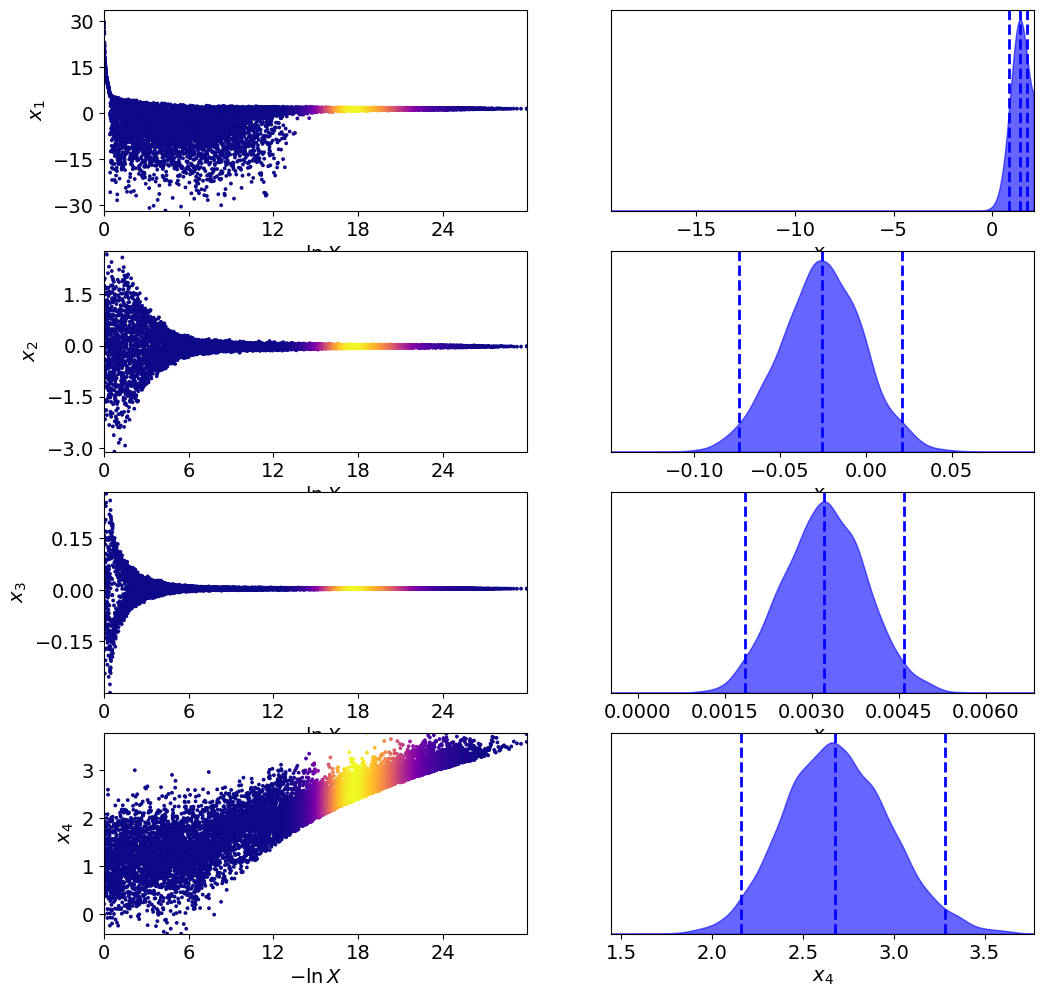

In [10]:
from ultranest.plot import cornerplot, traceplot, runplot

traceplot(sampler_single.run_sequence)
plt.show()

Next, we can look at the "run" plot, which shows how the estimated value of relevant quantities evolved through the run.

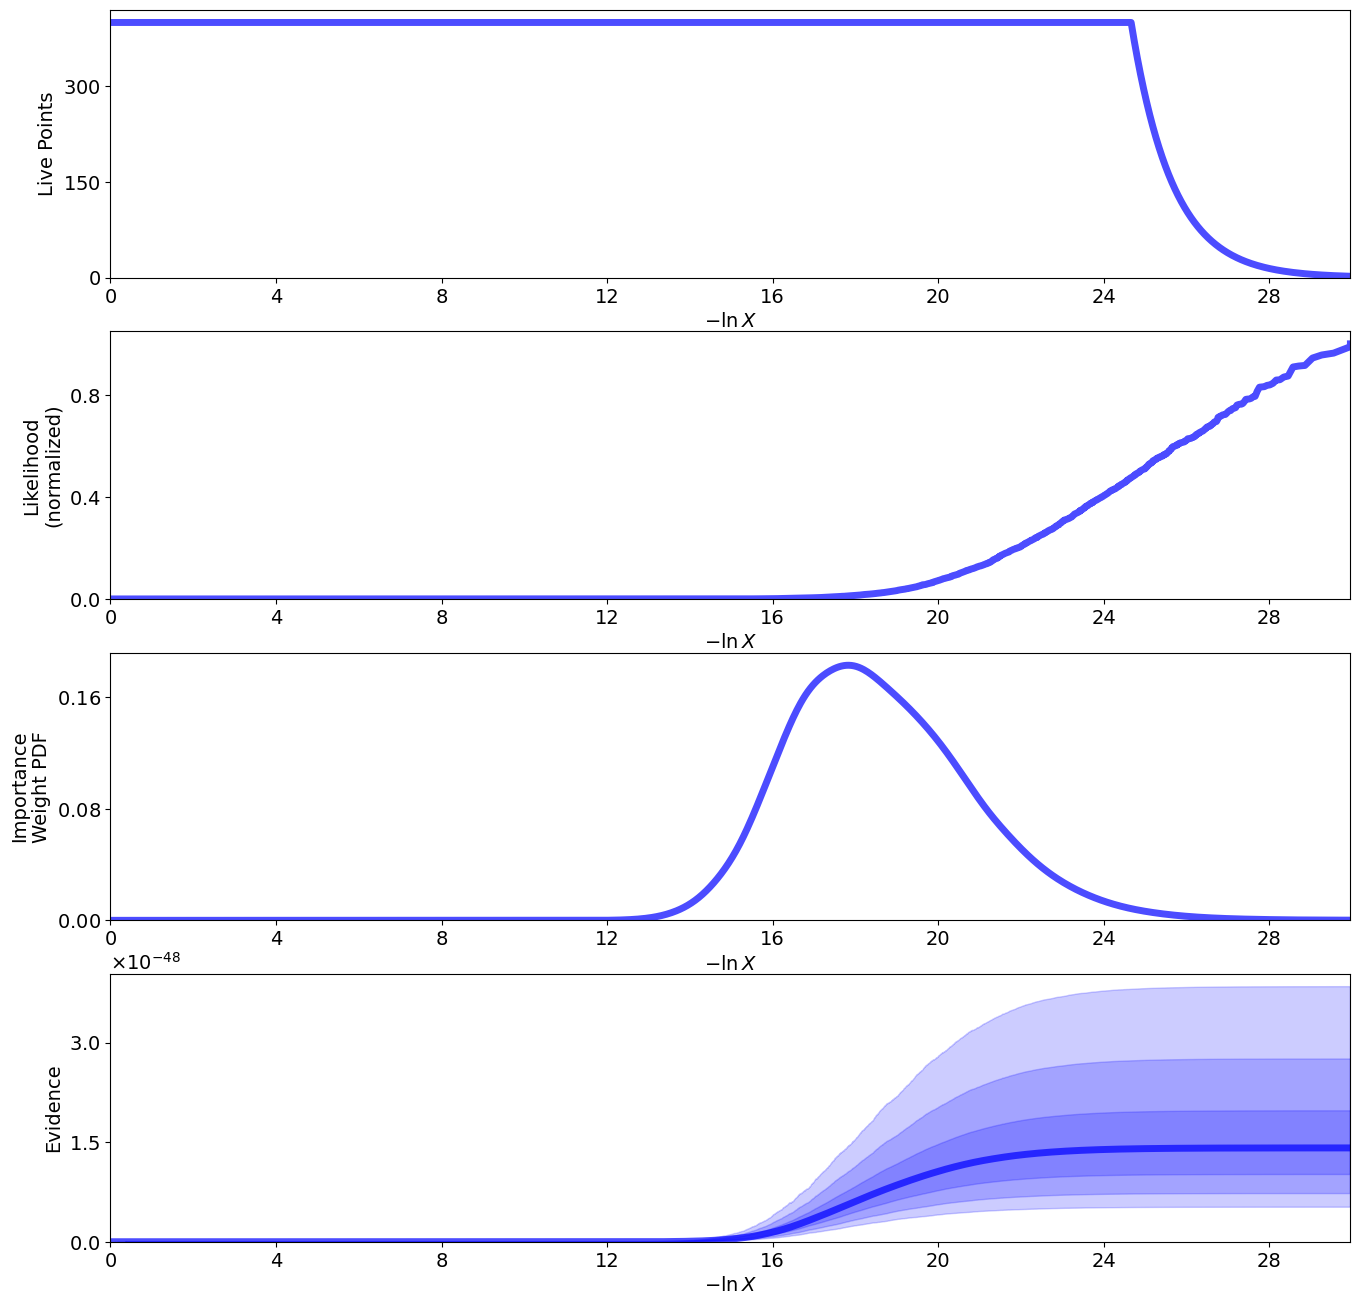

In [11]:
runplot(sampler_single.run_sequence)
plt.show()

And finally, we can look at the posterior distribution using `cornerplot`.

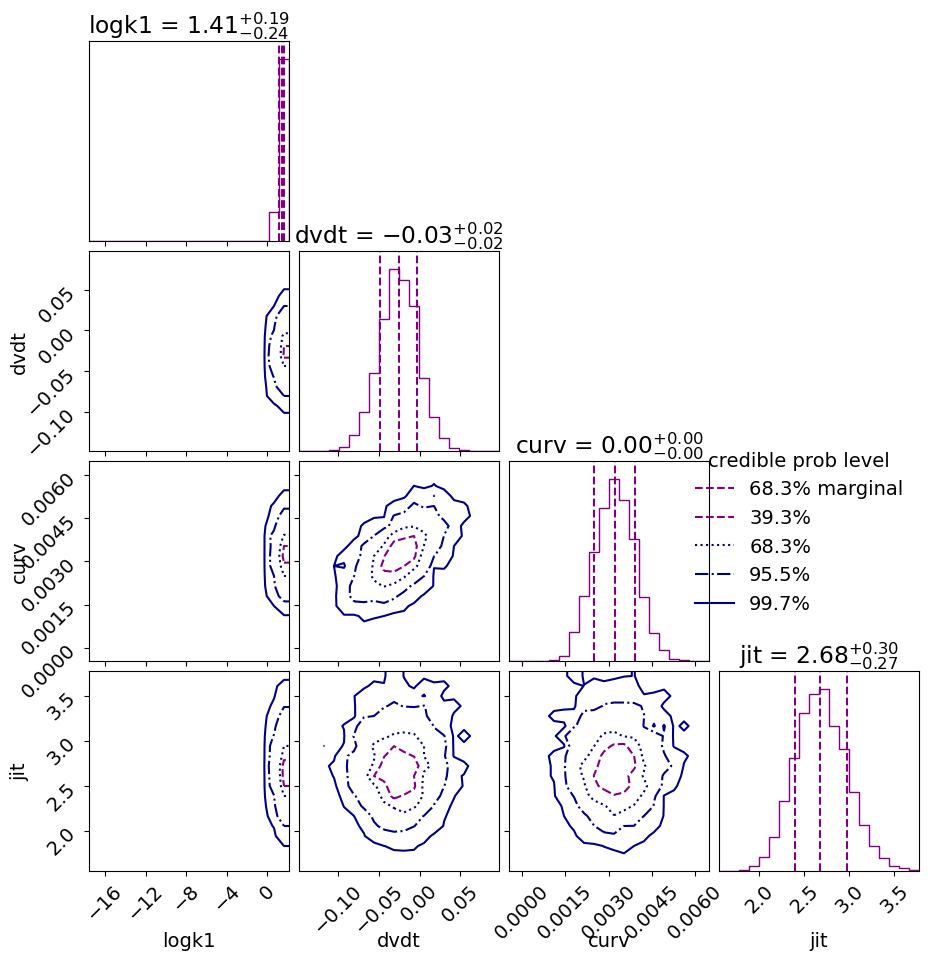

In [12]:
cornerplot(sampler_single.results)
plt.show()

Note that we could also have used directly the equally-weighted samples from our `results` dictionary as input to the `corner` package to generate a similar plot.

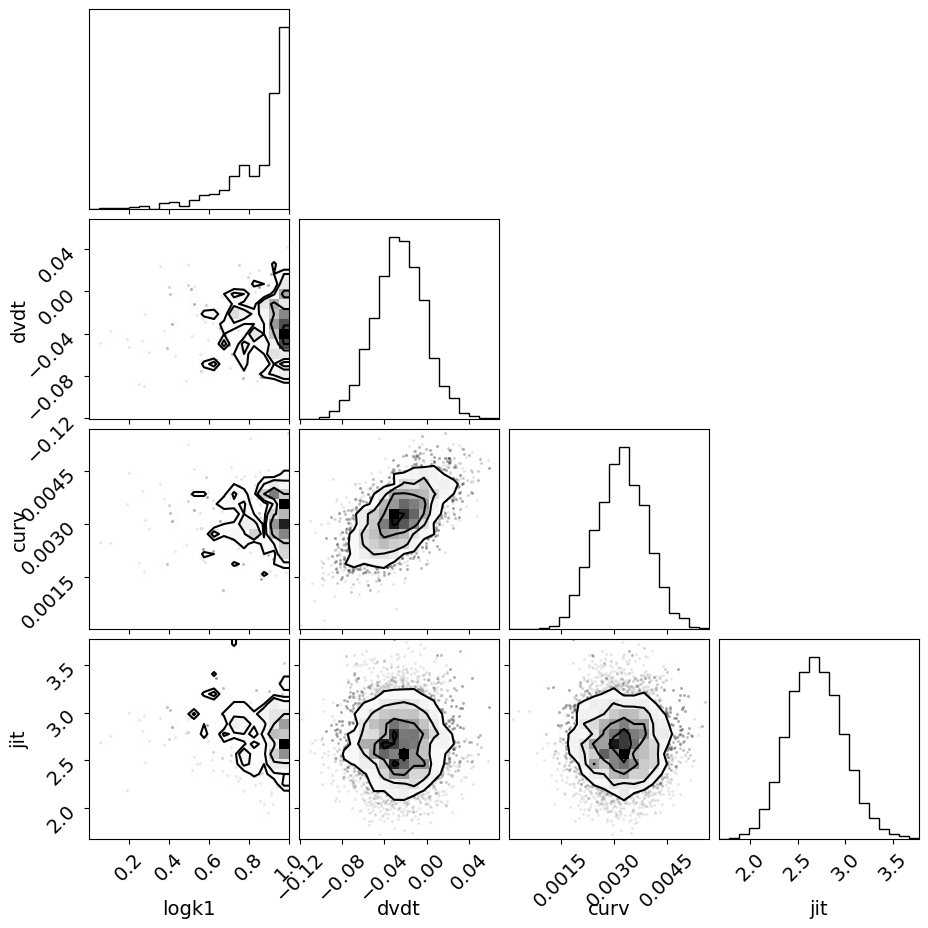

In [19]:
import corner
corner.corner(results_single["samples"].values[:, :-1], labels=post.name_vary_params(), range=[(0.001, 1.0), 1.0, 1.0, 1.0])
plt.show()

#### Bayesian Evidence

The log-evidence is in the nested sampling results under the `lnZ` key.
Let's extract it so it can be used for model comparison later.

In [20]:
logz_single = results_single["lnZ"]
logz_err_single = results_single["lnZerr"]
print(f"The log-evidence for the single-planet model is {logz_single:.2f} +/- {logz_err_single:.2f}")

The log-evidence for the single-planet model is -110.18 +/- 0.34


### Two-planet model

We will now repeat all of the above steps using a two-planet model.

First we create the model and check the priors.

In [21]:
post = initialize_model(2)

post.name_vary_params()

['logk1', 'logk2', 'dvdt', 'curv', 'jit']

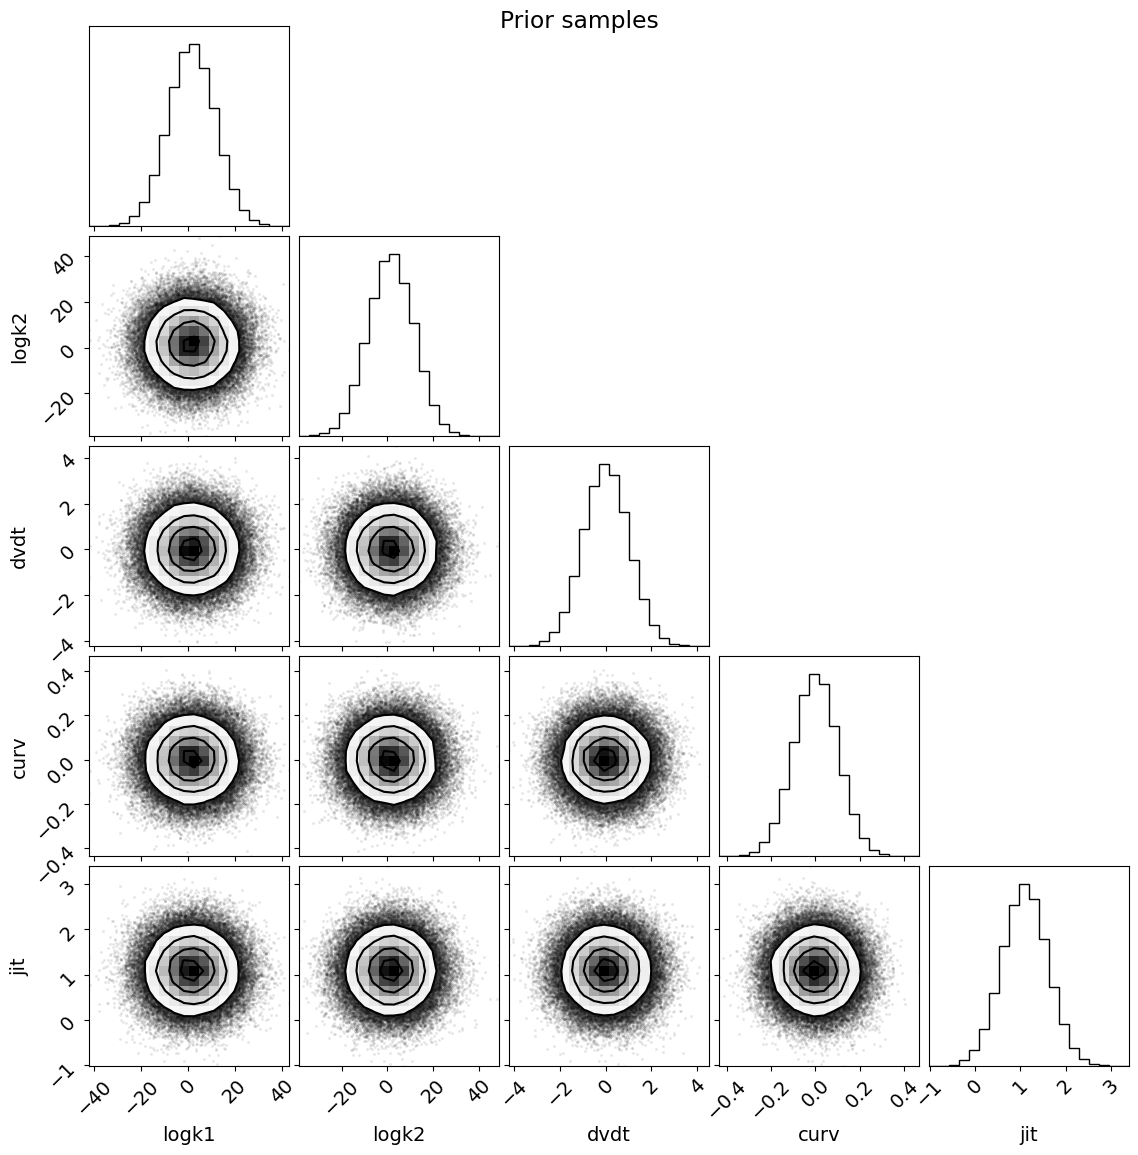

In [22]:
u = np.random.random(size=(len(post.name_vary_params()), 100_000))
prior_samples = post.prior_transform(u)

fig = corner.corner(prior_samples.T, labels=post.name_vary_params())
fig.suptitle("Prior samples")
plt.show()

We again optimize the parameters by maximizing the likelihood and plot the result

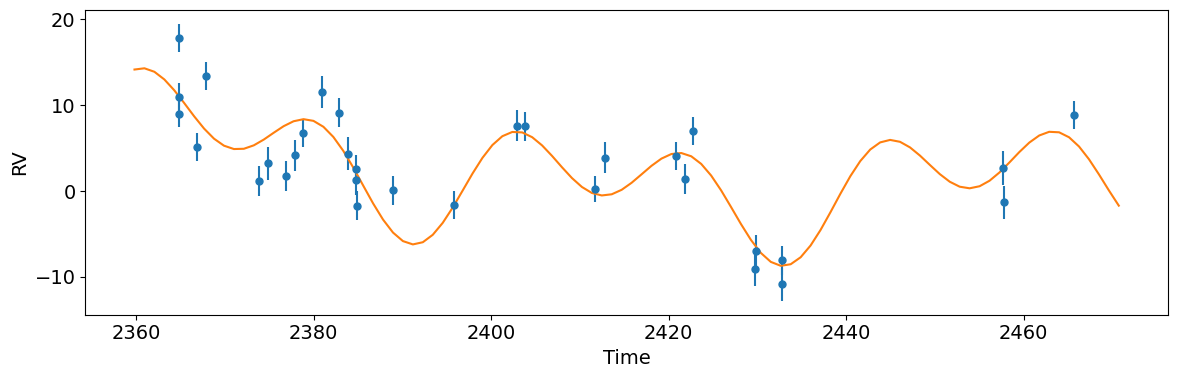

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                       1.54962       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                       1.37557       True
dvdt                     -0.0296175       True
curv                     0.00182308       True
gamma                      -4.00009      False
jit                         2.09057       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          4.70968           
tp2                         2077.33           
e2                           0.0002           
w2            

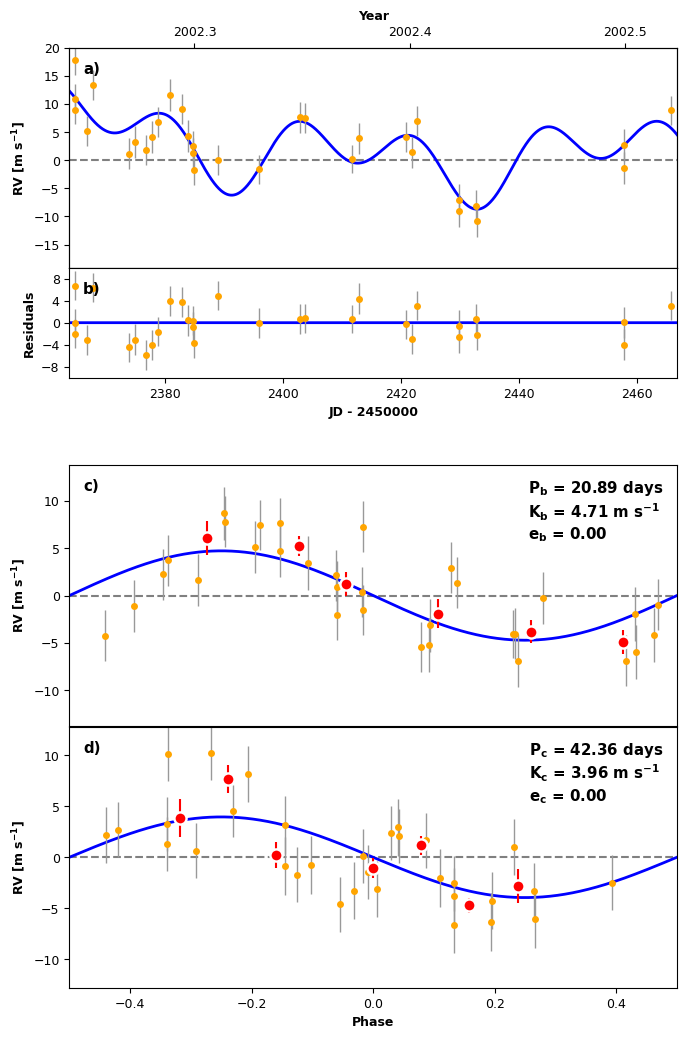

In [23]:
res  = optimize.minimize(
    post.neglogprob_array, 
    post.get_vary_params(), 
    method='Powell',)
bic_two = post.likelihood.bic()
plot_results(post.likelihood)
plt.show()
print(post)

RVPlot = orbit_plots.MultipanelPlot(post, legend=False)
RVPlot.plot_multipanel()
plt.show()

And we run nested sampling for this two-planet model.
We then store the evidence for the next section.

In [24]:
results_two = radvel.nested_sampling.run(post)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01  2 [-82.8805..-82.8805]*| it/evals=9880/411910 eff=2.4009% N=400    0     0 0  
[ultranest] Likelihood function evaluations: 411924
[ultranest]   logZ = -102.9 +- 0.1347
[ultranest] Effective samples strategy satisfied (ESS = 2672.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.13 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.


In [25]:
logz_two = results_two["lnZ"]
logz_err_two = results_two["lnZerr"]
print(f"The log-evidence for the two-planet model is {logz_two:.2f} +/- {logz_err_two:.2f}")

The log-evidence for the two-planet model is -102.86 +/- 0.29


### Model Comparison

The evidence $Z$, also called the marginal likelihood, gives the probability of obtaining the dataset under a given model.
Under the assumption of equal priors for the two models, the ratio of evidences, also called _Bayes factor_, provides a measure of the odds ratio between two models.
We can calculate the log of the Bayes factor by subtracting the evidences.

In [26]:
logb = logz_two - logz_single
logb_err = np.sqrt(logz_err_two**2 + logz_err_single**2)
print(f"Log of Bayes factor (two planet - one planet): {logb:.2f} +/- {logb_err:.2f}")

Log of Bayes factor (two planet - one planet): 7.32 +/- 0.44


This means that the odds ratio is overwhelmingly favorable to the two-planet model.